In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2, kstest, chi2_contingency


import pandas as pd
from numba import  njit

In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    #Wiener Process by default
    #use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    def Milstein2Solution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1], t_data[i - 1], self.params) - 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params)) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/2 * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) +\
                        1/4 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2 * self.sigmaxt_xx(x_data[i - 1], t_data[i - 1], self.params)) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/4 * self.bxt_xx(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2) * dt**2
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] - params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * 1/2 * 1/np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return -params[2] * 1/4 * 1/np.maximum(x,0)**(3/2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def ExactSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        Ito_integral_sum = np.zeros(self.Nx)
        for i in range(1, self.Nt + 1):
            Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data[i]) + theta1/theta2
            #avoiding exp overflow
            Ito_integral_sum = (Ito_integral_sum + theta3 * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]) * np.exp(-theta2 * dt)
            x_data[i] = Determinated_part + Ito_integral_sum
        return t_data, x_data

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1

        return ncx2.rvs(2 * q + 2, 2 * u, size = self.Nx) / (2 * c)

    def ProcessDistribution(self, x, t, x0, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
        u = c * x0 * np.exp(-k * (t - t0))
        #v = c * x
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c) #2c is normalazing constant

    def StationaryDistribution(self, x):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c)

Task 1. Simulate a Cox-Ingersoll-Ross (CIR) model
$$
dX_t = (\theta_1 - \theta_2 X_t)dt + \theta_3 \sqrt{X_t}dW_t
$$
with $\theta = (6, 2, 1)$, and choose the bandwidth according to Scott’s rule and implement the non-parametric kernel estimation for stationary density of the CIR model.

Plot in a graph the true stationary density against the estimated one for two approaches
*  compute on the single trajectory  (set $T$ very large, time discretization step set as $T/N_t = \Delta t$);
*  compute on the Nx trajectories.




In [3]:
def StationaryDistributionKernelEstimator(x, x_data, delta = None):
    n = len(x_data)
    m = 1

    hn = 1

    if delta is None:
        hn = np.std(x_data) * n**(-1 / (m + 4))
    else:
        hn = delta

    pi = np.zeros(len(x))

    for j in range(0, len(x)):
        K = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * (x[j] - x_data)**2 / hn**2)

        pi[j] = 1 / (n * hn) * np.sum(K)

    return pi

In [4]:
# approach 1

Nx = 1 
Nt = 100000
T = 1000


params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

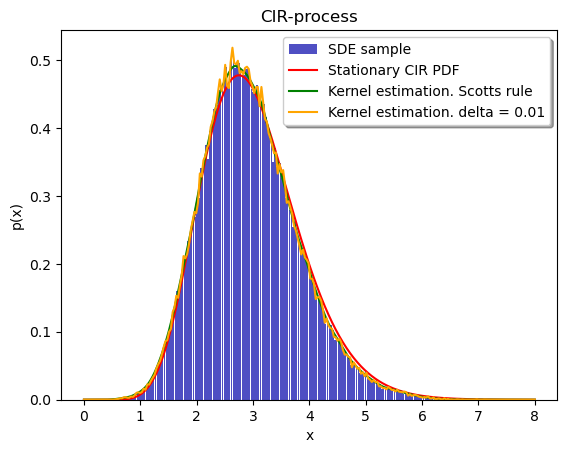

In [5]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR.flatten(), bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process', loc = 'center')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten()), label = f'Kernel estimation. Scotts rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten(), delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

In [6]:
# approach 2

Nx = 15000
Nt = 300

T = 1

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

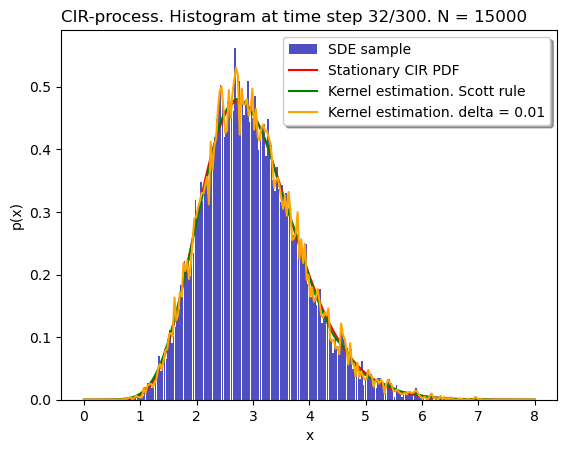

In [7]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process. Histogram at time step {i}/{Nt}. N = {Nx}', loc = 'left')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i]), label = f'Kernel estimation. Scott rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i], delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

Task. Estimate the quality of the obtained approximations with statistical criteria and provide conclusions.

In [8]:
stat_CIR_PDF = CIRp.StationaryDistribution(x_data)
stat_kernel_est_Scott_rule = StationaryDistributionKernelEstimator(x_data, x_data_CIR[i])
stat_kernel_est_delta = StationaryDistributionKernelEstimator(x_data, x_data_CIR[i], delta = d)

In [9]:
(stat_CIR_PDF.size, stat_kernel_est_Scott_rule.size, stat_kernel_est_delta.size)

(250, 250, 250)

In [10]:
# pd.DataFrame(stat_CIR_PDF).hist()
# plt.show()
# pd.DataFrame(stat_kernel_est_Scott_rule).hist()
# plt.show()
# pd.DataFrame(stat_kernel_est_delta).hist()
# plt.show()

In [11]:
from scipy import stats

* Начнем с $\chi^2$

In [12]:
def chi(data1, data2) -> np.array:    
    num_bins = 10  

    all_data_1 = np.concatenate([data1, data2])
    bins_1 = np.linspace(np.min(all_data_1), np.max(all_data_1), num_bins + 1)
    observed_frequencies_1, _ = np.histogram(data1, bins=bins_1)
    expected_frequencies_1, _ = np.histogram(data2, bins=bins_1)

    return observed_frequencies_1, expected_frequencies_1

In [13]:
observed_frequencies_1, expected_frequencies_1 = chi(stat_CIR_PDF, stat_kernel_est_Scott_rule) 
observed_frequencies_2, expected_frequencies_2 = chi(stat_CIR_PDF, stat_kernel_est_delta)

In [14]:
chi2_stat, p_value = stats.chisquare(observed_frequencies_1, expected_frequencies_1)
chi2_stat_2, p_value_2 = stats.chisquare(observed_frequencies_2, expected_frequencies_2)
print(f'Результаты для:(stat_CIR_PDF,stat_kernel_est_Scott_rule)\n chi2_stat:{chi2_stat}, p_value: {p_value}')
print()
print(f'Результаты для:(stat_CIR_PDF,stat_kernel_est_delta)\n chi2_stat:{chi2_stat_2}, p_value: {p_value_2}' )

Результаты для:(stat_CIR_PDF,stat_kernel_est_Scott_rule)
 chi2_stat:0.827020202020202, p_value: 0.9997433936595498

Результаты для:(stat_CIR_PDF,stat_kernel_est_delta)
 chi2_stat:18.837345283824156, p_value: 0.026611985274457718


* Высокое p-значение (почти 1) говорит о том, что наблюдаемое расхождение между двумя распределениями (гистограммами частот stat_CIR_PDF и stat_kernel_est_Scott_rule) крайне незначительное и может быть объяснено случайными вариациями в данных.

* Вывод: У нас нет оснований отвергать гипотезу о том, что оба распределения — stat_CIR_PDF и stat_kernel_est_Scott_rule — идентичны. Это говорит о том, что аппроксимация, полученная с использованием stat_kernel_est_Scott_rule, очень хорошо соответствует данным stat_CIR_PDF. Таким образом, можно заключить, что качество аппроксимации высокое.

* Stat_kernel_est_delta имеет более выраженные отклонения от исходного распределения (stat_CIR_PDF), чем stat_kernel_est_Scott_rule, у которого p-значение было намного выше. 
* Возможно, stat_kernel_est_delta использует параметры, которые не оптимально приближают распределение stat_CIR_PDF, и требуется корректировка параметров

---

* Далее по порядку
 1) Тест Колмогорова-Смирнова
 2) Тест Андерсона-Дарлинга

 3) Тест Крамера-фон Мизеса
 4) Коэффициент корреляции Спирмена
 5) Тест Бартлетта на равенство дисперсий

In [15]:
ks_2samp = stats.ks_2samp(stat_CIR_PDF, stat_kernel_est_Scott_rule)
anderson_ksamp = stats.anderson_ksamp([stat_CIR_PDF, stat_kernel_est_Scott_rule])
cramervonmises_2samp = stats.cramervonmises_2samp(stat_CIR_PDF, stat_kernel_est_Scott_rule)
spearmanr = stats.spearmanr(stat_CIR_PDF, stat_kernel_est_Scott_rule)
bartlett= stats.bartlett(stat_CIR_PDF, stat_kernel_est_Scott_rule)



ks_2samp_2 = stats.ks_2samp(stat_CIR_PDF, stat_kernel_est_delta)
anderson_ksamp_2 = stats.anderson_ksamp([stat_CIR_PDF, stat_kernel_est_delta])
cramervonmises_2samp_2 = stats.cramervonmises_2samp(stat_CIR_PDF, stat_kernel_est_delta)
spearmanr_2 = stats.spearmanr(stat_CIR_PDF, stat_kernel_est_delta)
bartlett_2 = stats.bartlett(stat_CIR_PDF, stat_kernel_est_delta)


C:\Users\Астемир\AppData\Local\Temp\ipykernel_12764\59152017.py:2: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  anderson_ksamp = stats.anderson_ksamp([stat_CIR_PDF, stat_kernel_est_Scott_rule])
C:\Users\Астемир\AppData\Local\Temp\ipykernel_12764\59152017.py:10: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  anderson_ksamp_2 = stats.anderson_ksamp([stat_CIR_PDF, stat_kernel_est_delta])


In [16]:
listik = [ks_2samp, anderson_ksamp, cramervonmises_2samp, spearmanr, bartlett]
listik_2 = [ks_2samp_2, anderson_ksamp_2, cramervonmises_2samp_2, spearmanr_2, bartlett_2]
print('Результаты для:(stat_CIR_PDF,stat_kernel_est_Scott_rule):')
print()

for i in listik:
    
    print(f' ------- {i} \n')

print('Результаты для:(stat_CIR_PDF,stat_kernel_est_delta):')
print()

for i in listik_2:
    
    print(f' ------- {i} \n')

Результаты для:(stat_CIR_PDF,stat_kernel_est_Scott_rule):

 ------- KstestResult(statistic=0.08, pvalue=0.4011233148855002, statistic_location=4.928250299027405e-05, statistic_sign=-1) 

 ------- Anderson_ksampResult(statistic=-0.5580405306526698, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.25) 

 ------- CramerVonMisesResult(statistic=0.047911999999996624, pvalue=0.8915276620126386) 

 ------- SignificanceResult(statistic=0.9956507464119424, pvalue=1.2024404714861359e-257) 

 ------- BartlettResult(statistic=0.0006894231486319381, pvalue=0.9790524569108958) 

Результаты для:(stat_CIR_PDF,stat_kernel_est_delta):

 ------- KstestResult(statistic=0.188, pvalue=0.0002808512396260602, statistic_location=2.4385644340688832e-18, statistic_sign=-1) 

 ------- Anderson_ksampResult(statistic=6.653575969727613, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001) 

 ------- CramerVonMisesResult(statistic=0.5190640000000002

In [17]:
results_scott_rule = pd.DataFrame({
    
    
    "Test": ["Kolmogorov-Smirnov", "Anderson-Darling", "Cramer-von Mises", "Spearman Correlation", "Bartlett Test"],
    "Statistic": [ks_2samp.statistic, anderson_ksamp.statistic, cramervonmises_2samp.statistic, spearmanr.correlation, bartlett.statistic],
    "p-value": [ks_2samp.pvalue, anderson_ksamp.significance_level, cramervonmises_2samp.pvalue, spearmanr.pvalue, bartlett.pvalue]


})

results_delta = pd.DataFrame({
    "Test": ["Kolmogorov-Smirnov", "Anderson-Darling", "Cramer-von Mises", "Spearman Correlation", "Bartlett Test"],
    "Statistic": [ks_2samp_2.statistic, anderson_ksamp_2.statistic, cramervonmises_2samp_2.statistic, spearmanr_2.correlation, bartlett_2.statistic],
    "p-value": [ks_2samp_2.pvalue, anderson_ksamp_2.significance_level, cramervonmises_2samp_2.pvalue, spearmanr_2.pvalue, bartlett_2.pvalue]
})

In [18]:
results_scott_rule

,Test,Statistic,p-value
0,Kolmogorov-Smirnov,0.080000,4.011233e-01
1,Anderson-Darling,-0.558041,2.500000e-01
2,Cramer-von Mises,0.047912,8.915277e-01
3,Spearman Correlation,0.995651,1.202440e-257
4,Bartlett Test,0.000689,9.790525e-01


In [19]:
results_delta

,Test,Statistic,p-value
0,Kolmogorov-Smirnov,0.188000,2.808512e-04
1,Anderson-Darling,6.653576,1.000000e-03
2,Cramer-von Mises,0.519064,3.564015e-02
3,Spearman Correlation,0.990935,3.194373e-218
4,Bartlett Test,0.037961,8.455216e-01


Task. Study the effect of the bandwidth $h_n$ and the mesh $∆_n$ on the kernel estimator and plot a 3D graph.

Calculating p-values across grid points:   0%|          | 0/58 [00:00<?, ?it/s]

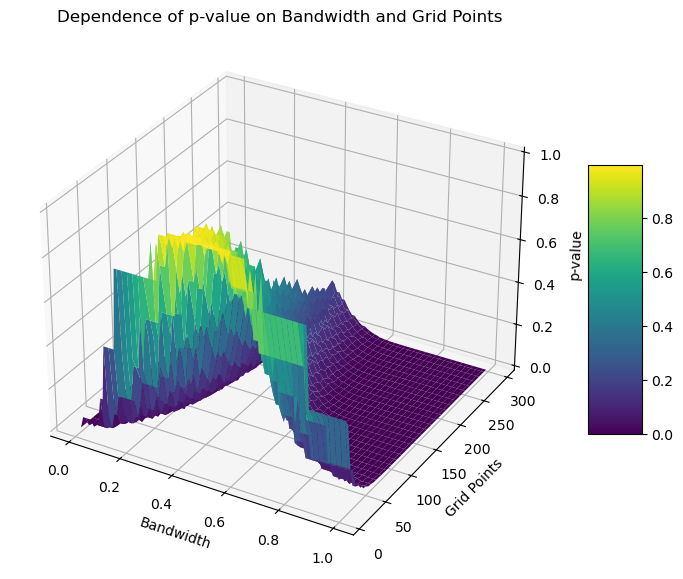

In [ ]:

from tqdm.notebook import tqdm

Nx = 30
Nt = 300
T = 1
params_CIR = [6, 2, 1]
np.random.seed(42)


rand_index = np.random.randint(0, Nt)  
grid_points = list(range(10, 300, 5))  
bandwidths = np.linspace(0.0001, 1, 100) 


cir_process = CIRprocess(params_CIR, T, Nx, Nt)
time_data, process_data = cir_process.ExactSolution()


p_results = []


for points in tqdm(grid_points, desc="Calculating p-values across grid points"):
    row = []
    data_grid = np.linspace(0, 8, points)
    theoretical_pdf = cir_process.StationaryDistribution(data_grid) 
    for bw in bandwidths:
    
        estimated_pdf = StationaryDistributionKernelEstimator(data_grid, process_data[rand_index], delta=bw)
        
        
        _, p_val = stats.ks_2samp(theoretical_pdf, estimated_pdf)
        row.append(p_val)
    p_results.append(row)


p_results = np.array(p_results)
X, Y = np.meshgrid(bandwidths, grid_points)
Z = p_results


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel('Bandwidth')
ax.set_ylabel('Grid Points')
ax.set_zlabel('p-value')
ax.set_title('Dependence of p-value on Bandwidth and Grid Points')

plt.show()


Task. Repeat previos tasks on the Chan-Karolyi-Longstaff-Sanders (CKLS) model
\begin{equation*}%\label{eq09}
 dX_{t} = (\theta_{1}+\theta_{2} X_{t}) dt + \theta_{3} X_{t}^{\theta_{4}} dW_{t},\qquad X_{0}=2
\end{equation*}
with $\theta_{1}=1$, $\theta_{2}=2$, $\theta_{3}=0.5$, $\theta_{4}=0.3$.

In [ ]:


class CKLSprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * x**params[3]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * params[3] * x**(params[3] - 1)

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return params[2] * params[3] * (params[3] - 1) * x**(params[3] - 2)

    def DefaultInitState(self):
        return np.ones(self.Nx) * 2  



In [22]:

Nx = 10000
Nt = 3000

T = 1

params_CKLS = [1., 2., 0.5, 0.3]

CKLS = CKLSprocess(params_CKLS, T, Nx, Nt)
CKLS.init_state = CKLS.DefaultInitState()
t_data, x_data_CKLS = CKLS.EulerSolution()

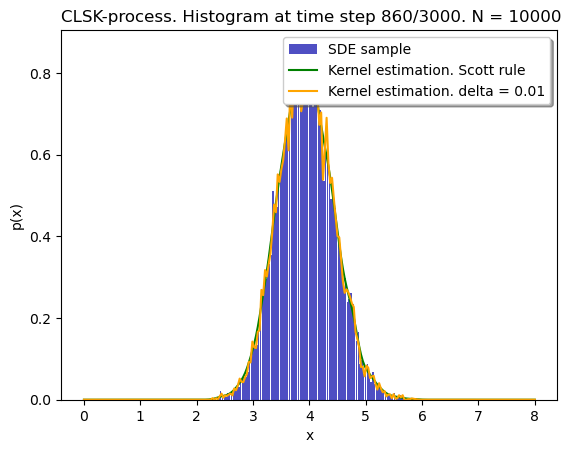

In [23]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

np.random.seed(42)
i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CKLS[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CLSK-process. Histogram at time step {i}/{Nt}. N = {Nx}', loc = 'left')

ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i]), label = f'Kernel estimation. Scott rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i], delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

In [24]:
stats_CKLS_SDE = x_data_CKLS[i]
stats_CKLS_Scott = StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i])
stats_CKLS_Delta = StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i], delta = d)

In [25]:
ks_2samp = stats.ks_2samp(stats_CKLS_SDE, stats_CKLS_Scott)
anderson_ksamp = stats.anderson_ksamp([stats_CKLS_SDE, stats_CKLS_Scott])
cramervonmises_2samp = stats.cramervonmises_2samp(stats_CKLS_SDE, stats_CKLS_Scott)
bartlett= stats.bartlett(stats_CKLS_SDE, stats_CKLS_Scott)



ks_2samp_2 = stats.ks_2samp(stats_CKLS_SDE, stats_CKLS_Delta)
anderson_ksamp_2 = stats.anderson_ksamp([stats_CKLS_SDE, stats_CKLS_Delta])
cramervonmises_2samp_2 = stats.cramervonmises_2samp(stats_CKLS_SDE, stats_CKLS_Delta)
bartlett_2 = stats.bartlett(stats_CKLS_SDE, stats_CKLS_Delta)


C:\Users\Астемир\AppData\Local\Temp\ipykernel_12764\3786888343.py:2: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  anderson_ksamp = stats.anderson_ksamp([stats_CKLS_SDE, stats_CKLS_Scott])
C:\Users\Астемир\AppData\Local\Temp\ipykernel_12764\3786888343.py:9: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  anderson_ksamp_2 = stats.anderson_ksamp([stats_CKLS_SDE, stats_CKLS_Delta])


In [26]:
listik = [ks_2samp, anderson_ksamp, cramervonmises_2samp, bartlett]
listik_2 = [ks_2samp_2, anderson_ksamp_2, cramervonmises_2samp_2, bartlett_2]
print('Результаты для:(stat_CIR_PDF,stat_kernel_est_Scott_rule):')
print()

for i in listik:
    
    print(f' ------- {i} \n')

print('Результаты для:(stat_CIR_PDF,stat_kernel_est_delta):')
print()

for i in listik_2:
    
    print(f' ------- {i} \n')

Результаты для:(stat_CIR_PDF,stat_kernel_est_Scott_rule):

 ------- KstestResult(statistic=1.0, pvalue=1.5e-323, statistic_location=0.7802649457126816, statistic_sign=-1) 

 ------- Anderson_ksampResult(statistic=1083.277347929928, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001) 

 ------- CramerVonMisesResult(statistic=81.30082926829269, pvalue=1.3564125045384401e-08) 

 ------- BartlettResult(statistic=173.9892748245031, pvalue=9.952372636718945e-40) 

Результаты для:(stat_CIR_PDF,stat_kernel_est_delta):

 ------- KstestResult(statistic=1.0, pvalue=1.5e-323, statistic_location=0.8396756959482086, statistic_sign=-1) 

 ------- Anderson_ksampResult(statistic=1116.9204264378584, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001) 

 ------- CramerVonMisesResult(statistic=81.30203368292683, pvalue=1.3567119871993327e-08) 

 ------- BartlettResult(statistic=170.1798247356297, pvalue=6.759134530003893e-39) 



In [27]:
results_scott_rule = pd.DataFrame({
    
    
    "Test": ["Kolmogorov-Smirnov", "Anderson-Darling", "Cramer-von Mises", "Bartlett Test"],
    "Statistic": [ks_2samp.statistic, anderson_ksamp.statistic, cramervonmises_2samp.statistic, bartlett.statistic],
    "p-value": [ks_2samp.pvalue, anderson_ksamp.significance_level, cramervonmises_2samp.pvalue, bartlett.pvalue]


})

results_delta = pd.DataFrame({
    "Test": ["Kolmogorov-Smirnov", "Anderson-Darling", "Cramer-von Mises", "Bartlett Test"],
    "Statistic": [ks_2samp_2.statistic, anderson_ksamp_2.statistic, cramervonmises_2samp_2.statistic,  bartlett_2.statistic],
    "p-value": [ks_2samp_2.pvalue, anderson_ksamp_2.significance_level, cramervonmises_2samp_2.pvalue, bartlett_2.pvalue]
})

In [28]:
results_scott_rule

,Test,Statistic,p-value
0,Kolmogorov-Smirnov,1.000000,1.482197e-323
1,Anderson-Darling,1083.277348,1.000000e-03
2,Cramer-von Mises,81.300829,1.356413e-08
3,Bartlett Test,173.989275,9.952373e-40


In [29]:
results_delta

,Test,Statistic,p-value
0,Kolmogorov-Smirnov,1.000000,1.482197e-323
1,Anderson-Darling,1116.920426,1.000000e-03
2,Cramer-von Mises,81.302034,1.356712e-08
3,Bartlett Test,170.179825,6.759135e-39


Calculating p-values for different grid sizes:   0%|          | 0/58 [00:00<?, ?it/s]

c:\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


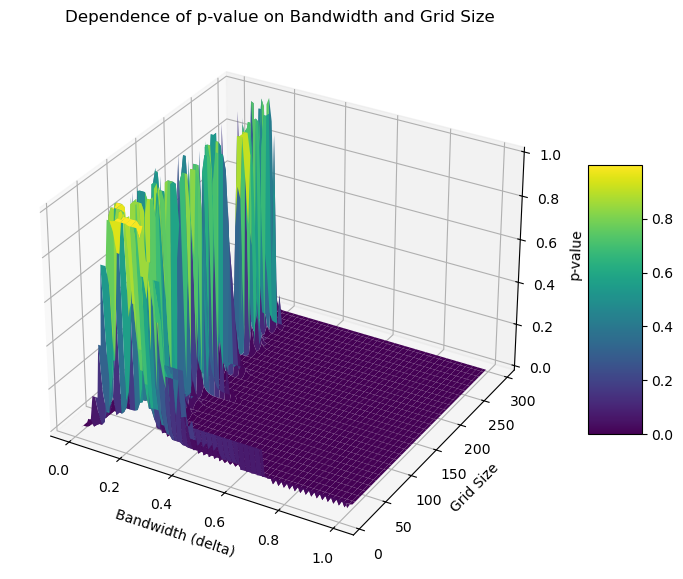

In [ ]:
Nx = 100
Nt = 300
T = 1
params_CKLS = [1., 2., 0.5, 0.3]
np.random.seed(41)

random_index = np.random.randint(0, Nt)  
grid_sizes = list(range(10, 300, 5))  
bandwidth_values = np.linspace(0.0001, 1, 100)  


p_results = []


for grid in tqdm(grid_sizes, desc="Calculating p-values for different grid sizes"):
    row = []
    data_grid = np.linspace(0, 8, grid)
    sample_index = np.random.randint(30, 100)
    
    
    ckls_process = CKLSprocess(params_CKLS, T, Nx, Nt)
    time_data, process_samples = ckls_process.EulerSolution()
    
    
    fixed_estimation = StationaryDistributionKernelEstimator(data_grid, process_samples[sample_index])
    
    for bw in bandwidth_values:
        
        delta_estimation = StationaryDistributionKernelEstimator(data_grid, process_samples[sample_index], delta=bw)
        
        
        stat_test = stats.ks_2samp(fixed_estimation, delta_estimation)
        stat, p_val = stat_test.statistic, stat_test.pvalue
        
        row.append(p_val)
    p_results.append(row)


p_results = np.array(p_results)
X, Y = np.meshgrid(bandwidth_values, grid_sizes)
Z = p_results


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)


ax.set_xlabel('Bandwidth (delta)')
ax.set_ylabel('Grid Size')
ax.set_zlabel('p-value')
ax.set_title('Dependence of p-value on Bandwidth and Grid Size')

plt.show()

Task 2. Implement a non-parametric drift estimator

$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}
$$

and diffusion estimator
$$
\hat{\sigma}^2_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)^2} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}.$$


for the CIR model (Task 1) and plot two graphs.
Use the Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$.


In [46]:
from typing import Literal

def NormalKernel(z):
    return 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * z**2)

def UniformKernel(z):
    return 1/2 * np.ones_like(z)

def ParabolicKernel(z):
    return 3/4 * (1 - z**2)

def Gaussian_high_order(z):
    pass

def DiffusionKernelEstimator(x, x_data, delta = None, 
                             method: Literal['normal', 'uniform', 'parabolic', 'gaussian_high_order'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        elif method == 'gaussian_high_order':
            K = Gaussian_high_order(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1])**2)
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

def DriftKernelEstimator(x, x_data, delta = None, 
                         method: Literal['normal', 'uniform', 'parabolic', 'gaussian_high_order'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        elif method == 'gaussian_high_order':
            K = Gaussian_high_order(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1]))
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

In [47]:
Nx = 1
Nt = 100000

T = 1000

x_data = np.linspace(0, 6, 200)

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
t_data, x_data_CIR = CIRp.ExactSolution()

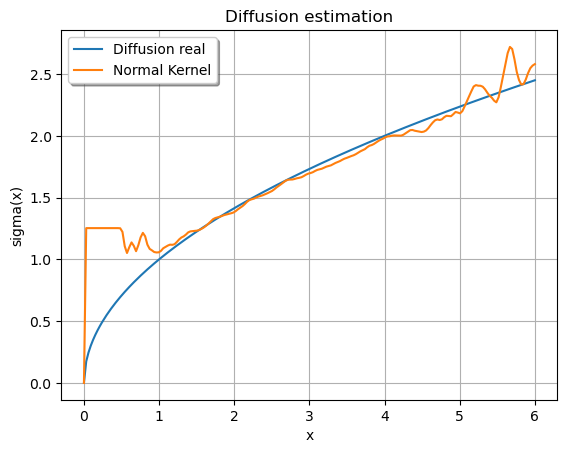

In [48]:
sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label = 'Diffusion real')


diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, np.sqrt(diffke), label = 'Normal Kernel')

#diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
#plt.plot(x_data, np.sqrt(diffke), label = 'Parabolic Kernel')

#diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
#plt.plot(x_data, np.sqrt(diffke), label = 'Uniform Kernel')

plt.title("Diffusion estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

In [49]:
Nx = 1
Nt = 100000

T = 1000

x_data = np.linspace(0, 6, 200)

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
t_data, x_data_CIR = CIRp.ExactSolution()

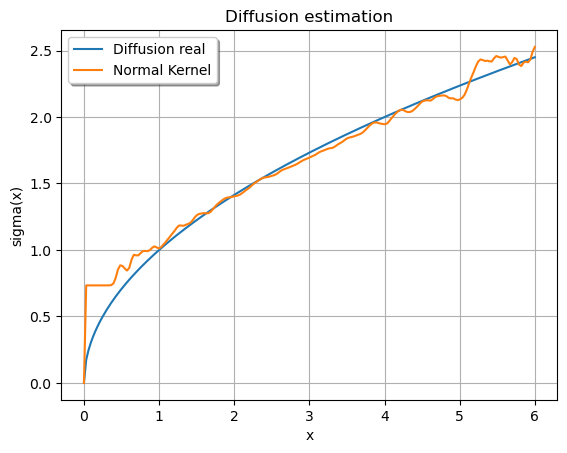

In [50]:
sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label = 'Diffusion real')


diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, np.sqrt(diffke), label = 'Normal Kernel')

#diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
#plt.plot(x_data, np.sqrt(diffke), label = 'Parabolic Kernel')

#diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
#plt.plot(x_data, np.sqrt(diffke), label = 'Uniform Kernel')

plt.title("Diffusion estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

Task. Implement a non-parametric drift
and diffusion estimators with the higher order Gaussian kernel $K(u)=\frac{3}{\sqrt{8 \pi}}(1-u^2/3)\exp({-u^2/2})$ ([p.24](https://www.nber.org/system/files/working_papers/w5345/w5345.pdf))  and add curves on graphs
for the CIR model.

Improve estimates on the left and the right subintervals $[0,1]$ and $[5,6]$ respectly.


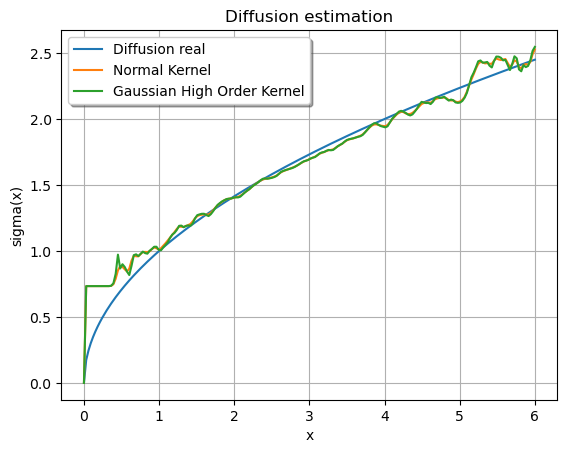

In [ ]:
def Gaussian_high_order(z):
    return 3 / np.sqrt(8 * np.pi) * (1 - z**2 / 3) * np.exp(-z**2 / 2)

Nx = 1
Nt = 100000

T = 1000

x_data = np.linspace(0, 6, 200)

params_CIR = [6, 2, 1]

sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label = 'Diffusion real')

diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, np.sqrt(diffke), label = 'Normal Kernel')

diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'gaussian_high_order')
plt.plot(x_data, np.sqrt(diffke), label = 'Gaussian High Order Kernel')


plt.title("Diffusion estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

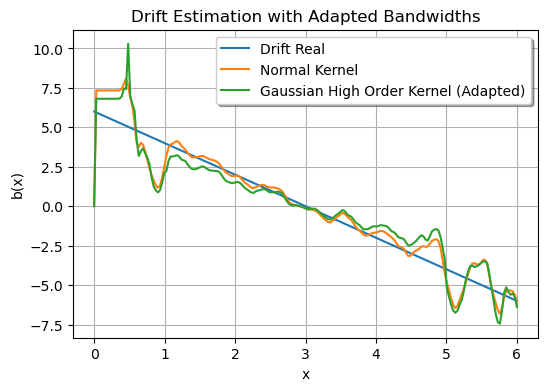

In [ ]:

b_data = CIRp.bxt(x_data, 0, params_CIR)



# Интервал [0, 1]
c_diffusion_left = 0.5
hn_diffusion_left = c_diffusion_left * Nt ** (-1 / 9)

c_drift_left = 0.5
hn_drift_left = c_drift_left * Nt ** (-1 / 3)

# Интервал [1, 5] 
c_diffusion_mid = 0.6
hn_diffusion_mid = c_diffusion_mid * Nt ** (-1 / 9)

c_drift_mid = 0.6
hn_drift_mid = c_drift_mid * Nt ** (-1 / 3)

# Интервал [5, 6]
c_diffusion_right = 0.45
hn_diffusion_right = c_diffusion_right * Nt ** (-1 / 9)

c_drift_right = 0.45
hn_drift_right = c_drift_right * Nt ** (-1 / 3)


diffke_high_order_left = DiffusionKernelEstimator(x_data[x_data <= 1], x_data_CIR.flatten(), hn_diffusion_left, 'gaussian_high_order')
diffke_high_order_mid = DiffusionKernelEstimator(x_data[(x_data > 1) & (x_data < 5)], x_data_CIR.flatten(), hn_diffusion_mid, 'gaussian_high_order')
diffke_high_order_right = DiffusionKernelEstimator(x_data[x_data >= 5], x_data_CIR.flatten(), hn_diffusion_right, 'gaussian_high_order')


diffke_high_order_combined = np.concatenate([
    np.sqrt(diffke_high_order_left),
    np.sqrt(diffke_high_order_mid),
    np.sqrt(diffke_high_order_right)
])


plt.figure(figsize=(6, 4))
plt.plot(x_data, b_data, label='Drift Real')


driftke_normal = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T / Nt, 'normal')
plt.plot(x_data, driftke_normal, label='Normal Kernel')


driftke_high_order_left = DriftKernelEstimator(x_data[x_data <= 1], x_data_CIR.flatten(), hn_drift_left, 'gaussian_high_order')
driftke_high_order_mid = DriftKernelEstimator(x_data[(x_data > 1) & (x_data < 5)], x_data_CIR.flatten(), hn_drift_mid, 'gaussian_high_order')
driftke_high_order_right = DriftKernelEstimator(x_data[x_data >= 5], x_data_CIR.flatten(), hn_drift_right, 'gaussian_high_order')


driftke_high_order_combined = np.concatenate([
    driftke_high_order_left,
    driftke_high_order_mid,
    driftke_high_order_right
])

plt.plot(x_data, driftke_high_order_combined, label='Gaussian High Order Kernel (Adapted)')

plt.title("Drift Estimation with Adapted Bandwidths")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()
